In [1]:
import catboost as cb
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import polars as pl
import seaborn as sns
from sklearn import metrics
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split

import util

In [2]:
RANDOM_SEED = 42
TEST_SIZE = 0.30

CHR19_MINHASH_AI_CHAINS = '/storage2/tbrekalo/HG002-simulated/chr19-ovlps-ram-ref.paf'
READ_ORIGINS = "/storage2/tbrekalo/HG002-simulated/chr19-read-origins.csv"

In [3]:
df_ovlps = util.load_paf_df(CHR19_MINHASH_AI_CHAINS)

In [4]:
df_origins = util.load_origins_df(READ_ORIGINS)

In [5]:
df_annotated = util.create_annotated_ref_overlaps(df_ovlps, df_origins)

In [21]:
df_featrues = df_annotated.select(
    (
        pl.col("query-end") - pl.col("query-start")
    ).alias("query-overlap-length"),

    (
        pl.col("target-end") - pl.col("target-start")
    ).alias("target-overlap-length"),

    pl.col("n-residue-matches"),
    (
        (pl.col("strand") == pl.col("origin-strand")) &
        (pl.col("ratio") > 0.875)
    ).cast(pl.Int64).alias("label")
).select(
    pl.min_horizontal(
        pl.col("query-overlap-length"),
        pl.col("target-overlap-length"),
        pl.col("overlap-length"),
    ).alias("overlap-length")
    (
        pl.min_horizontal(
            pl.col("query-overlap-length"),
            pl.col("target-overlap-length"),
        ) / pl.max_horizontal(
            pl.col("query-overlap-length"),
            pl.col("target-overlap-length"),
        )
    ).alias("overlap-ratio"),
    (
        pl.col("n-residue-matches") / pl.min_horizontal(
            pl.col("target-overlap-length"),
            pl.col("query-overlap-length"),
        )
    ).alias("normed-matches"),
    pl.col("label")
).filter(
    (pl.col("overlap-ratio") > 0.5)
).top_k(500_000, by="label")

<Axes: xlabel='label', ylabel='count'>

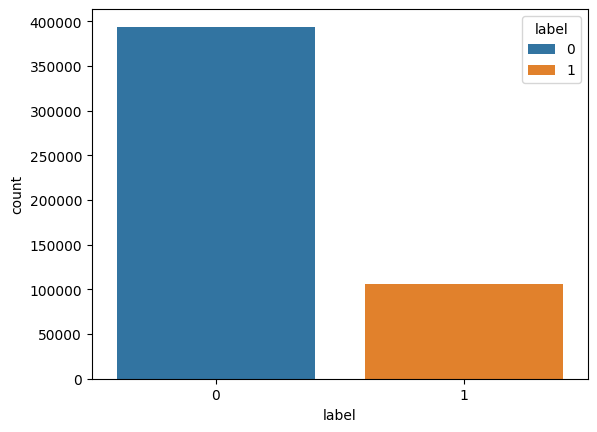

In [7]:
sns.barplot(
    df_featrues.select("label").to_series().value_counts().to_pandas(),
    x="label",
    y="count",
    hue="label",
)

In [8]:
df_featrues

overlap-ratio,normed-matches,label
f64,f64,i64
0.999837,0.505526,1
0.999939,0.040597,1
0.999569,0.564223,1
0.998583,0.553537,1
0.999283,0.494381,1
0.999943,0.531453,1
0.999895,0.504188,1
0.999938,0.56696,1
1.0,0.577034,1


<Axes: xlabel='overlap-ratio', ylabel='normed-matches'>

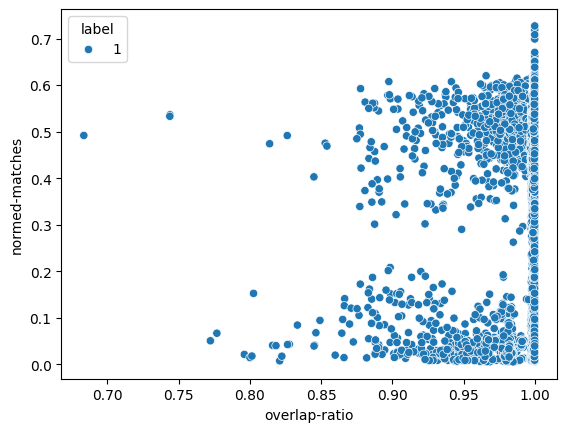

In [9]:
sns.scatterplot(df_featrues.filter(
    pl.col("label")  == 1
).to_pandas(), x="overlap-ratio", y="normed-matches", hue="label")

In [10]:
df_featrues = df_featrues.to_pandas()
df_featrues.head()

,overlap-ratio,normed-matches,label
0,0.999837,0.505526,1
1,0.999939,0.040597,1
2,0.999569,0.564223,1
3,0.998583,0.553537,1
4,0.999283,0.494381,1


In [11]:
X_train, X_test, y_train, y_test = train_test_split(
    df_featrues.drop("label", axis=1),
    df_featrues["label"],
    test_size=TEST_SIZE,
    random_state=RANDOM_SEED,
)

In [12]:
model_lr = LogisticRegression()
model_lr.fit(X_train, y_train)

LogisticRegression()

In [24]:
print(model_lr.intercept_, model_lr.coef_, model_lr.feature_names_in_)

[-55.65830431] [[50.96260308 12.78976175]] ['overlap-ratio' 'normed-matches']


/home/tbrekalo/dev/tb-ram/venv/lib/python3.11/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but LogisticRegression was fitted with feature names
  warnings.warn(


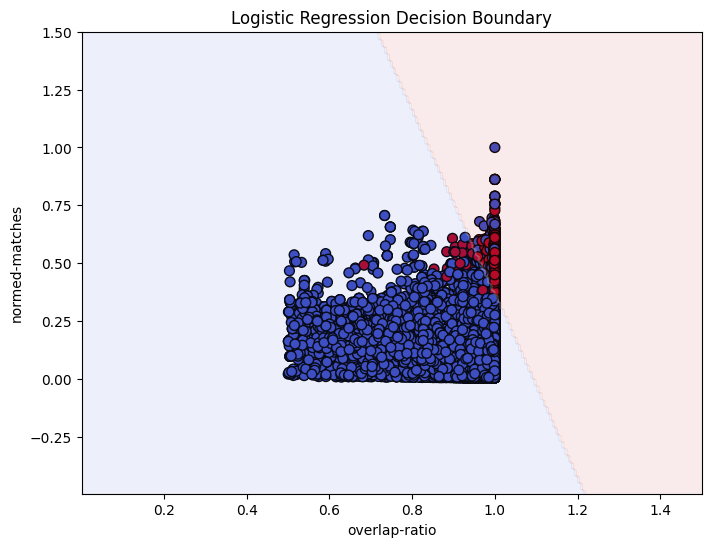

In [20]:
# Plot decision boundary and data points
plt.figure(figsize=(8, 6))

# Plot data points
plt.scatter(X_test["overlap-ratio"], X_test["normed-matches"], c=y_test, cmap=plt.cm.coolwarm, s=50, edgecolors='k')

# Plot decision boundary
x_min, x_max = X_test["overlap-ratio"].min() - .5, X_test["overlap-ratio"].max() + .5
y_min, y_max = X_test["normed-matches"].min() - .5, X_test["normed-matches"].max() + .5
xx, yy = np.meshgrid(np.linspace(x_min, x_max, 200), np.linspace(y_min, y_max, 200))
Z = model_lr.predict(np.c_[xx.ravel(), yy.ravel()])
Z = Z.reshape(xx.shape)
plt.contourf(xx, yy, Z, cmap=plt.cm.coolwarm, alpha=0.1)

plt.xlabel('overlap-ratio')
plt.ylabel('normed-matches')
plt.title('Logistic Regression Decision Boundary')
plt.show()

In [16]:
y_pred = model_lr.predict(X_test)
print(metrics.classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.98      0.97      0.97    118106
           1       0.89      0.92      0.90     31894

    accuracy                           0.96    150000
   macro avg       0.93      0.94      0.94    150000
weighted avg       0.96      0.96      0.96    150000



In [17]:
params_cb = {
    "iterations": 1_000,
    "loss_function": "Logloss",
    "boosting_type": "Plain",
    "verbose": False,
    "max_depth": 2,
    "random_seed": RANDOM_SEED
}
model_cb = cb.CatBoostClassifier(**params_cb)

In [18]:
model_cb.fit(X_train, y_train)

In [19]:
y_pred = model_cb.predict(X_test)
print(metrics.classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.98      0.98      0.98    118106
           1       0.92      0.92      0.92     31894

    accuracy                           0.97    150000
   macro avg       0.95      0.95      0.95    150000
weighted avg       0.97      0.97      0.97    150000

